**Principal Component Analysis in Asia FX**

> This analysis applies Principal Component Analysis (PCA) to evaluate monthly fluctuations in Asian currencies against USD. The distinction between statistical estimations and actual market movements highlights qualitative factors such as headlines, rumors, and investor sentiment. These deviations raise important questions regarding whether currency movements are exaggerated or understated, potentially leading to actionable trade ideas.
> 
> The analysis focuses on ten currencies: `cnh`, `hkd`, `twd`, `krw`, `inr`, `idr`, `php`, `myr`, `thb`, `sgd`. It utilizes a dataset comprising 100 months of historical observations across four major quantitative factors: `carry` (FX carry), `equity` (stock indices), `energy` (energy prices), and `fed` (Fed policy outlook). By identifying the principal components (PCs), this study aims to derive statistically estimated changes in Asian currencies on a monthly basis.

In [14]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

currencies = ['cnh', 'hkd', 'twd', 'krw', 'inr', 'idr', 'php', 'myr', 'thb', 'sgd']
for c in currencies:
    df = pd.read_excel('/Users/apple/Book1.xls', sheet_name=c, index_col=0, parse_dates=True)
    df.columns = ['carry', 'equity', 'energy', 'fed']
    scaled_data = StandardScaler().fit_transform(df.fillna(0))
    globals()[f'pca_{c}'] = PCA(n_components=0.95)
    globals()[f'pc_{c}'] = pd.DataFrame(globals()[f'pca_{c}'].fit_transform(scaled_data), index=df.index)
    globals()[f'loadings_{c}'] = pd.DataFrame(globals()[f'pca_{c}'].components_.T, index=df.columns)

> The following presents the PCA biplots which illustrates the scores of the observations on the PCs.

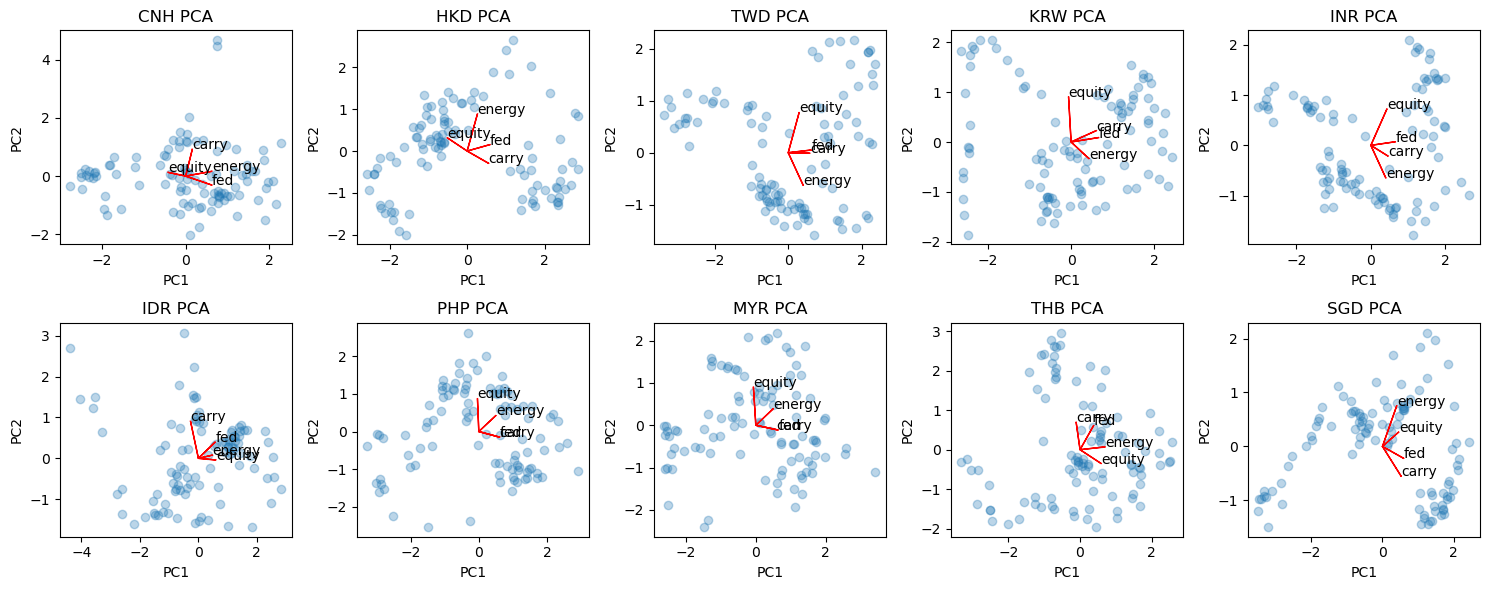

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, c in enumerate(currencies):
    pc, ld = globals()[f'pc_{c}'], globals()[f'loadings_{c}']
    axes.flat[i].scatter(pc[0], pc[1] if 1 in pc.columns else pc[0]*0, alpha=0.3)
    for f in ld.index: axes.flat[i].arrow(0, 0, ld.loc[f, 0], ld.loc[f, 1] if 1 in ld.columns else 0, color='r'); axes.flat[i].text(ld.loc[f, 0], ld.loc[f, 1] if 1 in ld.columns else 0, f)
    axes.flat[i].set(xlabel='PC1', ylabel='PC2', title=f'{c.upper()} PCA')
plt.tight_layout(); plt.show()

> The following presents the proportion of variance explained (PVE) by the PCs. The first two PCs capture around 80% or more of the total variance in most currencies. However `cnh` should require three PCs for subsequent analysis.

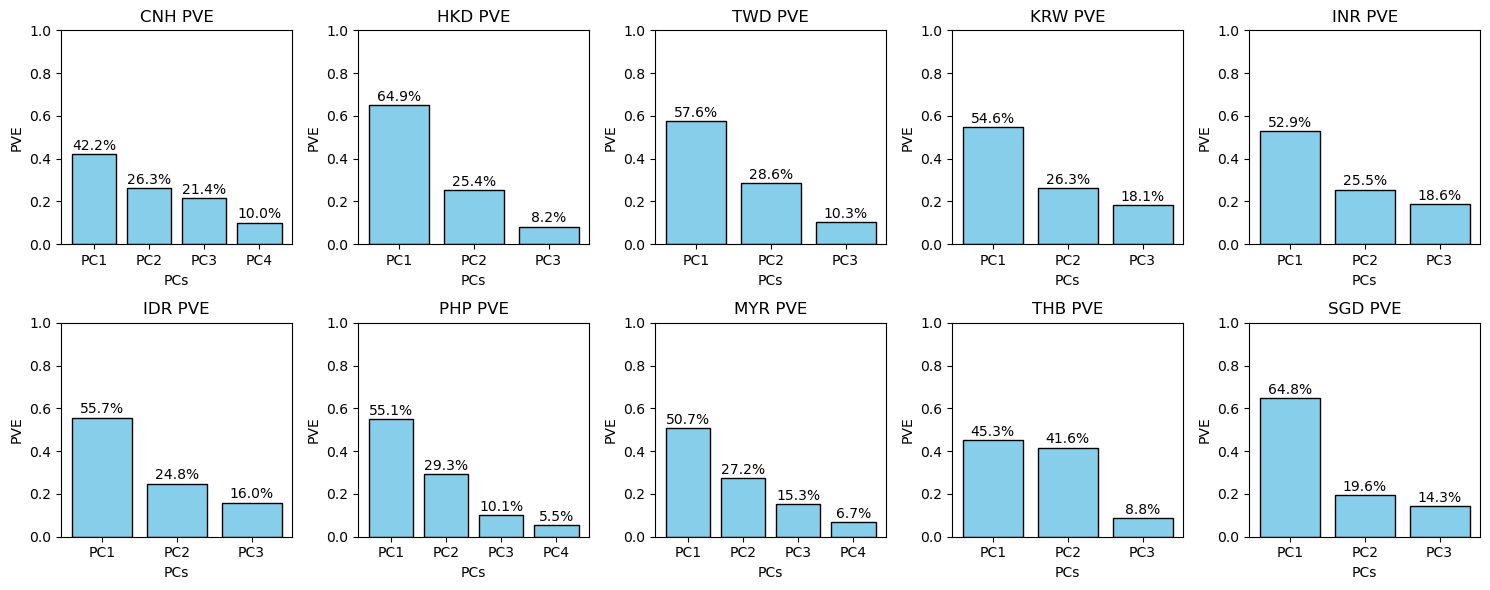

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, c in enumerate(currencies):
    pve = globals()[f'pca_{c}'].explained_variance_ratio_
    axes.flat[i].bar([f'PC{j+1}' for j in range(len(pve))], pve, color='skyblue', edgecolor='black')
    axes.flat[i].set(title=f'{c.upper()} PVE', xlabel='PCs', ylabel='PVE', ylim=(0, 1))
    for j, v in enumerate(pve): axes.flat[i].text(j, v + 0.02, f'{v*100:.1f}%', ha='center')
plt.tight_layout(); plt.show()

> The following selects the top 2-3 PCs and estimates the PCA-based monthly fluctuation of Asian currencies against USD in the target month (April 2025).

In [17]:
# select top PCs for 100 monthly observation periods
for c in currencies:
    df = pd.read_excel('/Users/apple/Book1.xls', sheet_name=c, index_col=0, parse_dates=True)
    df.columns = ['carry', 'equity', 'energy', 'fed']
    scaled_data = StandardScaler().fit_transform(df.fillna(0))
    n_comp = 3 if c == 'cnh' else 2
    pca = PCA(n_components=n_comp)
    globals()[f'pc_{c}'] = pd.DataFrame(pca.fit_transform(scaled_data), index=df.index, columns=range(n_comp))
    globals()[f'loadings_{c}'] = pd.DataFrame(pca.components_.T, index=df.columns, columns=range(n_comp))
    globals()[f'df_{c}'] = df

# get factors for new monthly observations period (April 2025)
for c in currencies:
    df_new = pd.read_excel('/Users/apple/Book3.xls', sheet_name=c, index_col=0, parse_dates=True)
    df_new.columns = ['carry', 'equity', 'energy', 'fed']
    globals()[f'new_{c}'] = df_new

# get monthly changes for 100 monthly observation periods and new monthly observation period 
fx_data = pd.read_excel('/Users/apple/Book6.xls', index_col=0, parse_dates=True)
new_fx_data = pd.read_excel('/Users/apple/Book8.xls', index_col=0, parse_dates=True)

In [18]:
# run PCA-based estimation
predictions = {}
for c in currencies:
    df = globals()[f'df_{c}']
    pc = globals()[f'pc_{c}']
    loadings = globals()[f'loadings_{c}']
    new_df = globals()[f'new_{c}']
    scaler = StandardScaler().fit(df)
    new_scaled = scaler.transform(new_df.fillna(0))
    new_pc = new_scaled @ loadings
    model = LinearRegression().fit(pc, fx_data[c])
    predictions[c] = model.predict(new_pc)[0]
pred_df = pd.DataFrame(predictions, index=new_df.index)

> The following compares the actual and PCA-based monthly fluctuation Asian currencies against USD in the target month.

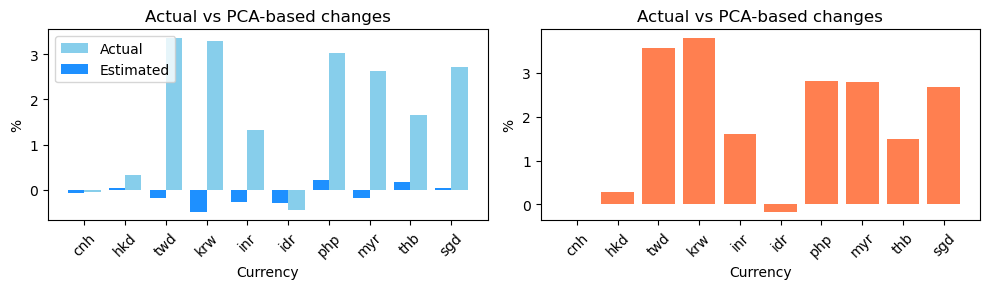

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
x = range(len(currencies))
ax1.bar([i + 0.2 for i in x], new_fx_data.iloc[0], width=0.4, label='Actual', color='skyblue')
ax1.bar([i - 0.2 for i in x], pred_df.iloc[0], width=0.4, label='Estimated', color='dodgerblue')
ax1.set_xticks(x, currencies, rotation=45); ax1.set_xlabel('Currency'); ax1.set_ylabel('%')
ax1.set_title('Actual vs PCA-based changes'); ax1.legend()
ax2.bar(currencies, new_fx_data.iloc[0] - pred_df.iloc[0], color='coral')
ax2.set_xticks(range(len(currencies)), currencies, rotation=45); ax2.set_xlabel('Currency'); ax2.set_ylabel('%')
ax2.set_title('Actual vs PCA-based changes')
plt.tight_layout(); plt.show()

> Asian currencies generally outperformed the PCA-based estimations in the target month. While the statistical estimations effectively captured the quantitative factors driving the market, the differences between actual and PCA-based changes highlighted the influence of qualitative factors, such as headlines, on market outcomes.
> 
> In the context of the target month, tariff risks and trade tensions remained dominant factors contributing to the narrative of USD weakening, which explains the outperformance of Asian FX. Notably, the extent of outperformance observed in TWD and KRW compared to Southeast Asian currencies is informative.
>
> This tool offers broad applicability as the identified correlations could provide directional guidance when strong market convictions are lacking during other time periods. It is particularly relevant for G10 currencies that exhibit greater variation and can also be applied to other asset classes such as commodities.